# Overview

This notebook analyzes breast cancer gene expression data using UMAP for dimensionality reduction and explores the relationships between key clinical biomarkers:

- **Biomarkers analyzed:**  
    - Estrogen receptor (ER)  
    - HER2  
    - Progesterone receptor (PGR)  
    - KI67

- **Workflow steps:**  
    - Data loading and preprocessing  
    - UMAP embedding and visualization  
    - Unsupervised clustering and statistical testing  
    - Supervised machine learning to predict biomarker status from UMAP features  
    - Model evaluation and interpretation

The goal is to assess the utility of UMAP-based embeddings for clinical prediction tasks and biomarker stratification.

# UMAP
In the first step, I load bo the clinical metadata, the collapsed dataset (that was not zscored), and the z-scored dataset.

I'm doing the same analysis as for PAM50 but for the individual cancer biomarkers.

## Imports

In [34]:
import os
from pathlib import Path
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    silhouette_score, accuracy_score, classification_report, confusion_matrix, adjusted_rand_score
)
from sklearn.model_selection import (
    cross_val_score, train_test_split, GridSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from scipy.stats import f_oneway, kruskal

import umap


## Load Data

In [35]:
# Load environment variables and find repo root
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()

# Load clinical data
clinical_path = repo_root / os.getenv("CLINICAL")
clinical_df = pd.read_csv(clinical_path, index_col=0)

clinical_path = repo_root / os.getenv("CLINICAL_IMPUTED")
clinical_df_imputed = pd.read_csv(clinical_path, index_col=0)

# Load expression (z-scored) data
zscored_path = repo_root / os.getenv("ZSCORED_QUALITY_CHECKED")
zscored_df = pd.read_csv(zscored_path, index_col=0)

# Make sure both dataframes have the same samples and are in the same order
common_samples = clinical_df.index.intersection(zscored_df.index)
clinical_df = clinical_df.loc[common_samples]
zscored_df = zscored_df.loc[common_samples]


collapsed_path = repo_root / os.getenv("EM_COLLAPSED")
collapsed_df = pd.read_csv(collapsed_path, index_col=0)

common_samples = clinical_df.index.intersection(collapsed_df.index)
clinical_df = clinical_df.loc[common_samples]
collapsed_df = collapsed_df.loc[common_samples]

print(f"Zscored data shape: {zscored_df.shape}")
print(f"Collapsed (not zscored) data shape: {collapsed_df.shape}")
print(f"Clinical data shape: {clinical_df.shape}")

Zscored data shape: (3273, 26150)
Collapsed (not zscored) data shape: (3273, 26150)
Clinical data shape: (3273, 34)


In [36]:
print(f"Clinical data shape: {clinical_df.shape}")
print(f"Collapsed data shape: {collapsed_df.shape}")

Clinical data shape: (3273, 34)
Collapsed data shape: (3273, 26150)


## Overview of Biomarkers with UMAP

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


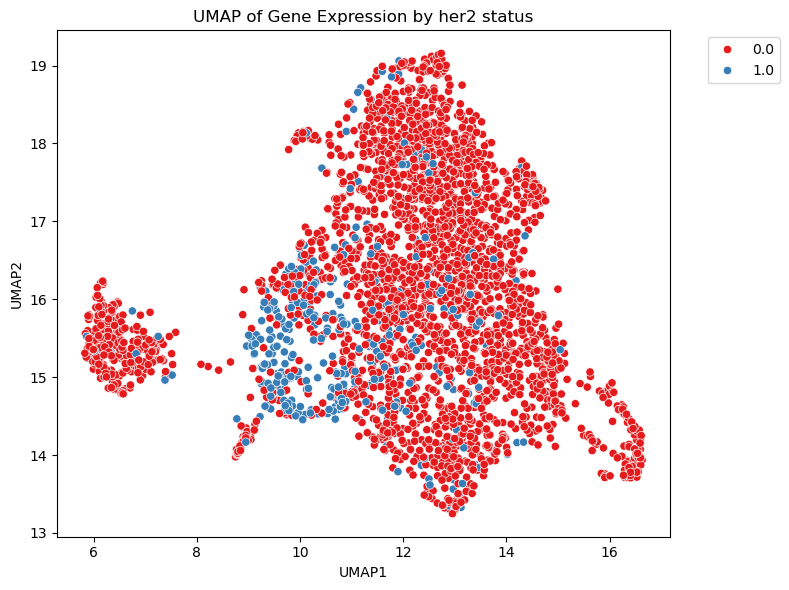

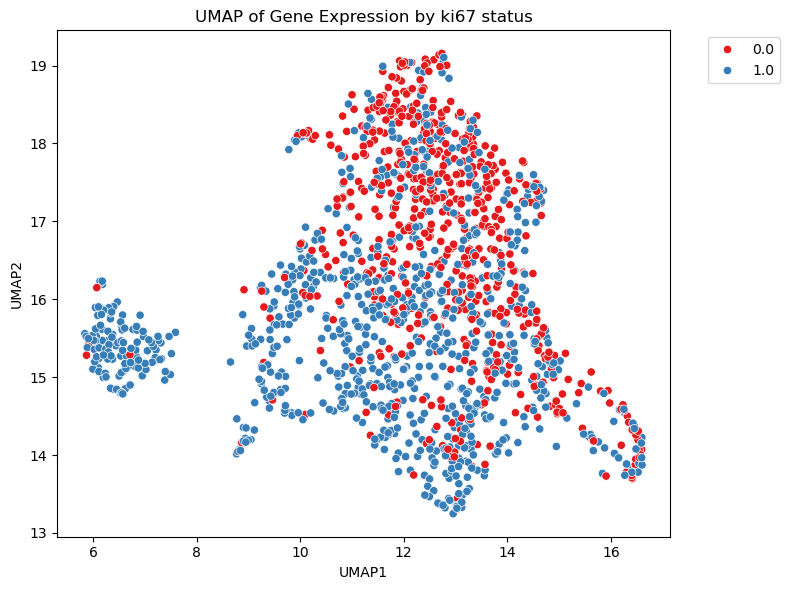

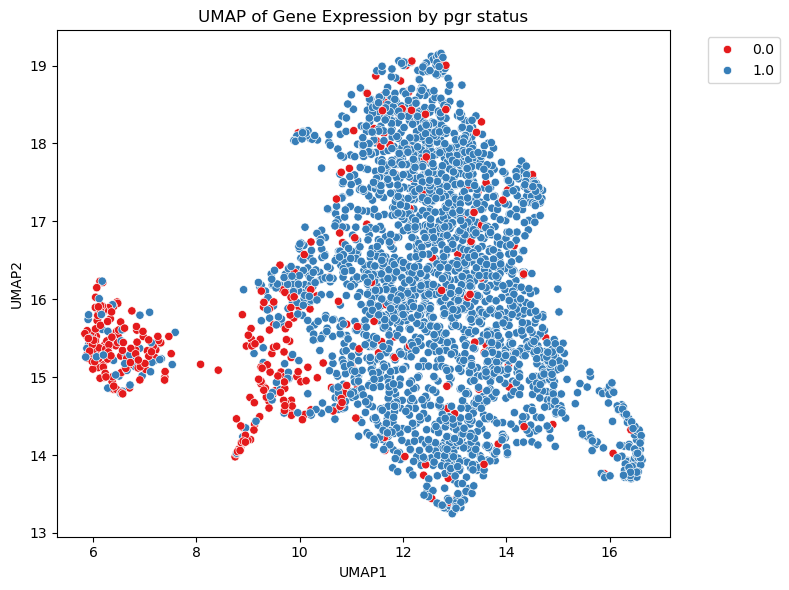

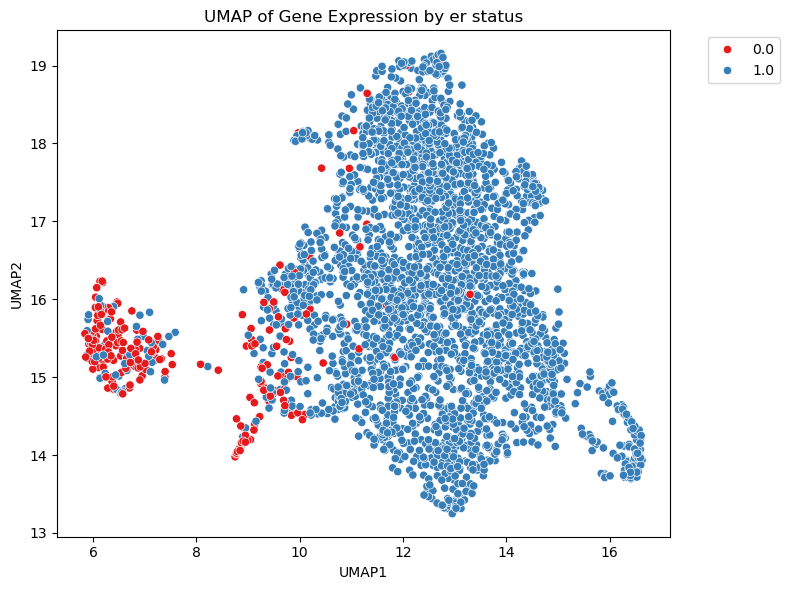

In [37]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(collapsed_df.values)
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=collapsed_df.index)
umap_df = umap_df.join(clinical_df)

# Plot for each biomarker
for biomarker in ['her2 status', 'ki67 status', 'pgr status', 'er status']:
    if biomarker in umap_df.columns:
        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x='UMAP1', y='UMAP2',
            data=umap_df,
            hue=biomarker,
            palette='Set1'
        )
        plt.title(f'UMAP of Gene Expression by {biomarker}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

## ER Status
Estrogen receptor status -> matters for therapy and prognosis.

Comment: There are some NaNs in the ER status column from the clinical metadataset - for this analysis, I drop the instances with NA because I wouldn't want to have instances in the model that were imputed in the target column.

In [38]:
# Drop all samples with NaN in ER status BEFORE UMAP and apply to both clinical_df and collapsed_df

er_col = [col for col in clinical_df.columns if "er status" in col.lower()]
if er_col:
    er_status = clinical_df[er_col[0]]
    # Align index for mask to both dataframes
    valid_index = er_status.dropna().index
    clinical_df = clinical_df.loc[valid_index]
    collapsed_df = collapsed_df.loc[valid_index]
    print(f"Number of samples after dropping NaN ER status: {clinical_df.shape[0]}")
else:
    print("No ER status column found in clinical_df.")

Number of samples after dropping NaN ER status: 3073


In [39]:
N = 8000 
gene_variances = collapsed_df.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(N).index
collapsed_df = collapsed_df[top_genes]


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


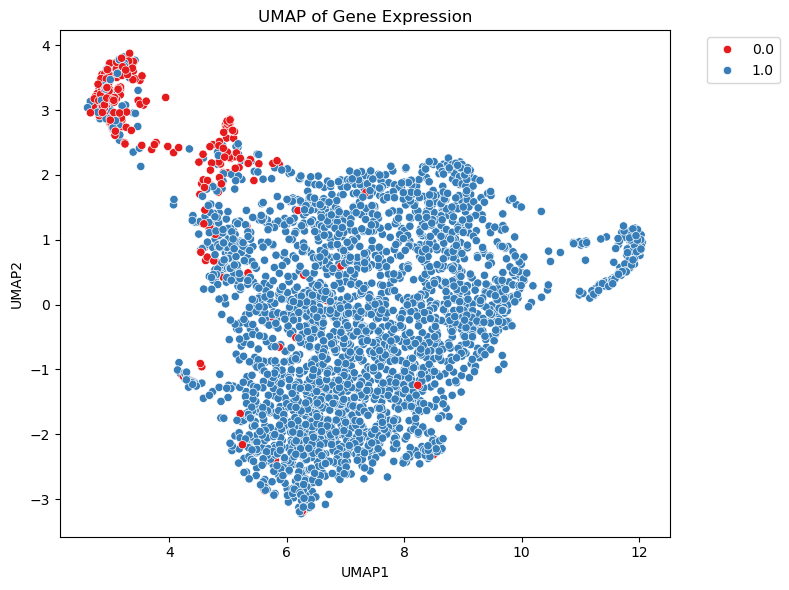

In [40]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(collapsed_df.values)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=collapsed_df.index)
umap_df = umap_df.join(clinical_df)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    data=umap_df, 
    hue='er status',    
    palette='Set1'
)
plt.title('UMAP of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
label_col = 'er status'
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(clinical_df[label_col].astype(str))

In [42]:
class_names = label_encoder.classes_

In [43]:
sil_umap = silhouette_score(umap_result, labels)
print(f"UMAP Silhouette Score (w.r.t {label_col}): {sil_umap:.3f}")


UMAP Silhouette Score (w.r.t er status): 0.393


In [44]:
# UMAP1 axis
groups1 = [umap_df['UMAP1'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap1 = f_oneway(*groups1).pvalue
print(f"ANOVA p-value for UMAP1 between {label_col} groups: {anova_umap1:.3e}")

# UMAP2 axis
groups2 = [umap_df['UMAP2'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap2 = f_oneway(*groups2).pvalue
print(f"ANOVA p-value for UMAP2 between {label_col} groups: {anova_umap2:.3e}")


ANOVA p-value for UMAP1 between er status groups: 4.429e-170
ANOVA p-value for UMAP2 between er status groups: 9.140e-148


In [45]:
kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(umap_result)
ari = adjusted_rand_score(labels, kmeans.labels_)
print(f"Adjusted Rand Index (ARI) between k-means clusters and {label_col}: {ari:.3f}")


Adjusted Rand Index (ARI) between k-means clusters and er status: 0.326


# Supervised ML on UMAP Embeddings

## Logistic Regression

In [46]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"Logistic Regression accuracy on UMAP embedding: {scores.mean():.3f} ± {scores.std():.3f}")


Logistic Regression accuracy on UMAP embedding: 0.950 ± 0.013


## Random Forest (5-fold CV)

In [47]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ---- Cross-Validation (CV) ----
cv_scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"Random Forest CV accuracy on UMAP embedding: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    umap_result, labels, test_size=0.2, random_state=42, stratify=labels
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Random Forest test set accuracy on UMAP embedding: {test_acc:.3f}")
print("Classification report on test set:\n", classification_report(y_test, y_pred, target_names=["ER negative", "ER positive"]))


Random Forest CV accuracy on UMAP embedding: 0.953 ± 0.009
Random Forest test set accuracy on UMAP embedding: 0.951
Classification report on test set:
               precision    recall  f1-score   support

 ER negative       0.71      0.62      0.67        48
 ER positive       0.97      0.98      0.97       567

    accuracy                           0.95       615
   macro avg       0.84      0.80      0.82       615
weighted avg       0.95      0.95      0.95       615



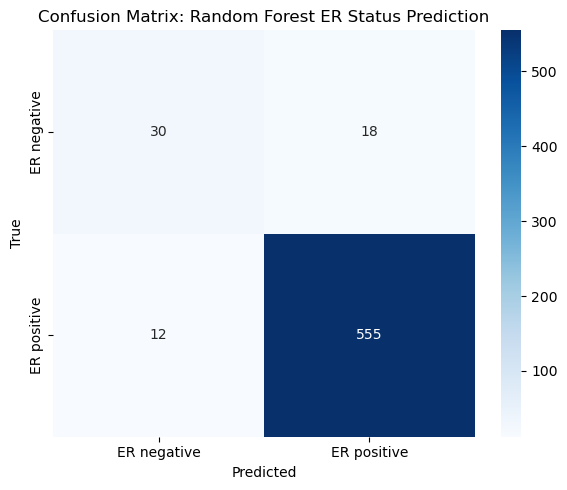

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["ER negative", "ER positive"],
            yticklabels=["ER negative", "ER positive"])
plt.title(f"Confusion Matrix: Random Forest ER Status Prediction")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [49]:
from sklearn.metrics import classification_report

# Print classification report with class names
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

         0.0       0.71      0.62      0.67        48
         1.0       0.97      0.98      0.97       567

    accuracy                           0.95       615
   macro avg       0.84      0.80      0.82       615
weighted avg       0.95      0.95      0.95       615



### Grid Search on UMAP for ER Status


Grid search for LogisticRegression...
Best params: {'C': 0.01, 'solver': 'liblinear'}
Best CV accuracy: 0.936

Grid search for RandomForest...
Best params: {'max_depth': 10, 'n_estimators': 100}
Best CV accuracy: 0.958

Grid search for SVC...
Best params: {'C': 0.1, 'kernel': 'rbf'}
Best CV accuracy: 0.912

LogisticRegression test set accuracy: 0.954
Classification report:
               precision    recall  f1-score   support

 ER negative       0.67      0.83      0.74        48
 ER positive       0.99      0.96      0.98       567

    accuracy                           0.95       615
   macro avg       0.83      0.90      0.86       615
weighted avg       0.96      0.95      0.96       615



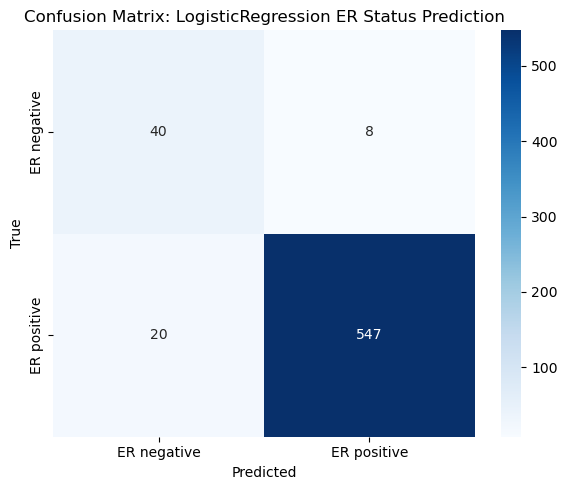


RandomForest test set accuracy: 0.964
Classification report:
               precision    recall  f1-score   support

 ER negative       0.76      0.79      0.78        48
 ER positive       0.98      0.98      0.98       567

    accuracy                           0.96       615
   macro avg       0.87      0.89      0.88       615
weighted avg       0.96      0.96      0.96       615



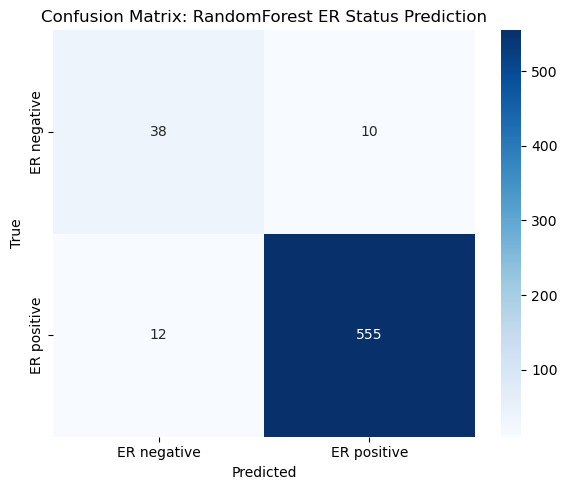


SVC test set accuracy: 0.933
Classification report:
               precision    recall  f1-score   support

 ER negative       0.54      0.90      0.68        48
 ER positive       0.99      0.94      0.96       567

    accuracy                           0.93       615
   macro avg       0.77      0.92      0.82       615
weighted avg       0.96      0.93      0.94       615



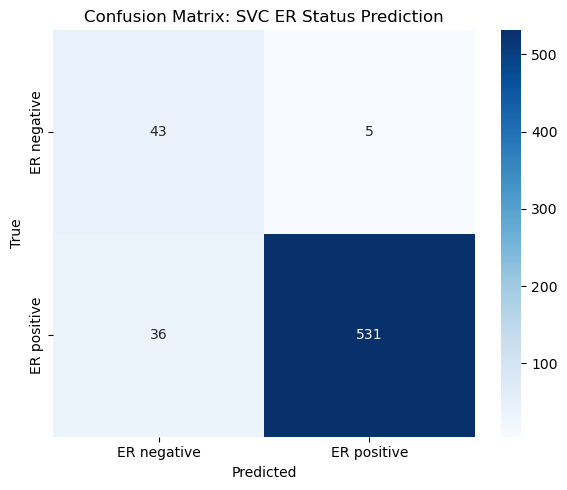

In [50]:
# Prepare data: exclude samples with missing ER status
er_col = [col for col in clinical_df.columns if "er status" in col.lower()]
if er_col:
    er_status = clinical_df[er_col[0]]
    valid_mask = ~er_status.isnull()
    X_umap = umap_df.loc[valid_mask, ["UMAP1", "UMAP2"]]
    y_er = er_status[valid_mask].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_umap, y_er, test_size=0.2, random_state=42, stratify=y_er
    )

    # Define models and parameter grids
    models_and_params = {
        "LogisticRegression": (
            LogisticRegression(class_weight="balanced", max_iter=1000),
            {
                "C": [0.01, 0.1, 1, 10, 100],
                "solver": ["liblinear", "lbfgs"]
            }
        ),
        "RandomForest": (
            RandomForestClassifier(class_weight="balanced", random_state=42),
            {
                "n_estimators": [50, 100, 200],
                "max_depth": [None, 5, 10, 20]
            }
        ),
        "SVC": (
            SVC(class_weight="balanced", probability=True, random_state=42),
            {
                "C": [0.1, 1, 10],
                "kernel": ["linear", "rbf"]
            }
        )
    }

    best_models = {}
    for name, (model, param_grid) in models_and_params.items():
        print(f"\nGrid search for {name}...")
        grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train, y_train)
        print(f"Best params: {grid.best_params_}")
        print(f"Best CV accuracy: {grid.best_score_:.3f}")
        best_models[name] = grid.best_estimator_

    # Evaluate best models on test set
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n{name} test set accuracy: {acc:.3f}")
        print("Classification report:\n", classification_report(y_test, y_pred, target_names=["ER negative", "ER positive"]))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["ER negative", "ER positive"],
                    yticklabels=["ER negative", "ER positive"])
        plt.title(f"Confusion Matrix: {name} ER Status Prediction")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
else:
    print("No ER status column found in clinical_df.")

## HER2 Status
HER2 may be harder to predict solely on UMAP embeddings because the distribution isn't as nice as with ER status (where it was mostly two clusters).

But interesting to know because human epidermal growth factor receptor 2 is a protein involved in cell growth -> tumours that are positive tend to grow faster and more aggressive.
-> Knowing HER2 status guides treatment --> targeted therapies like herceptin
-> helps predict prognosis and treatment response

### Grid Search for HER2


Grid search for LogisticRegression...
Best params: {'C': 0.1, 'solver': 'liblinear'}
Best CV accuracy: 0.727

Grid search for RandomForest...
Best params: {'max_depth': 20, 'n_estimators': 100}
Best CV accuracy: 0.878

Grid search for SVC...
Best params: {'C': 10, 'kernel': 'rbf'}
Best CV accuracy: 0.765

LogisticRegression test set accuracy: 0.737
Classification report:
               precision    recall  f1-score   support

 ER negative       0.93      0.75      0.83       518
 ER positive       0.27      0.63      0.38        75

    accuracy                           0.74       593
   macro avg       0.60      0.69      0.60       593
weighted avg       0.85      0.74      0.78       593



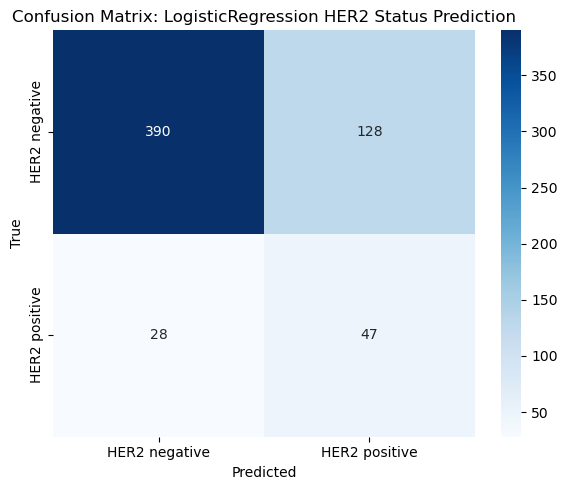


RandomForest test set accuracy: 0.860
Classification report:
               precision    recall  f1-score   support

 ER negative       0.89      0.96      0.92       518
 ER positive       0.37      0.15      0.21        75

    accuracy                           0.86       593
   macro avg       0.63      0.55      0.57       593
weighted avg       0.82      0.86      0.83       593



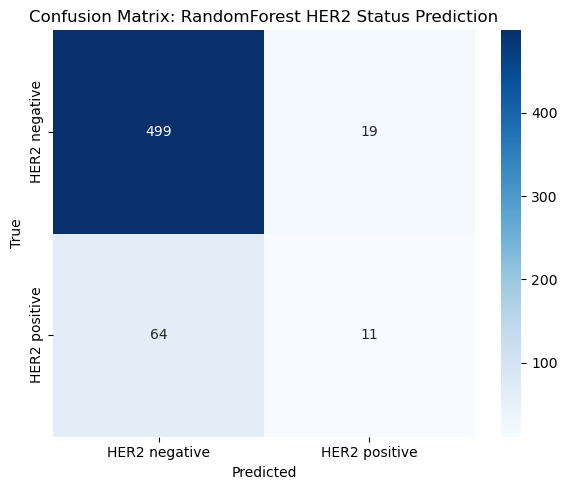


SVC test set accuracy: 0.755
Classification report:
               precision    recall  f1-score   support

 ER negative       0.93      0.78      0.85       518
 ER positive       0.28      0.59      0.38        75

    accuracy                           0.76       593
   macro avg       0.60      0.68      0.61       593
weighted avg       0.85      0.76      0.79       593



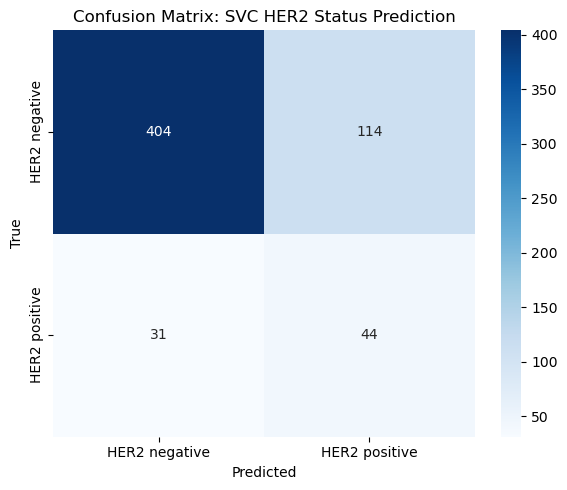

In [51]:
er_col = [col for col in clinical_df.columns if "her2 status" in col.lower()]
if er_col:
    her2_status = clinical_df[er_col[0]]
    valid_mask = ~her2_status.isnull()
    X_umap = umap_df.loc[valid_mask, ["UMAP1", "UMAP2"]]
    y_er = her2_status[valid_mask].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_umap, y_er, test_size=0.2, random_state=42, stratify=y_er
    )

    # Define models and parameter grids
    models_and_params = {
        "LogisticRegression": (
            LogisticRegression(class_weight="balanced", max_iter=1000),
            {
                "C": [0.01, 0.1, 1, 10, 100],
                "solver": ["liblinear", "lbfgs"]
            }
        ),
        "RandomForest": (
            RandomForestClassifier(class_weight="balanced", random_state=42),
            {
                "n_estimators": [50, 100, 200],
                "max_depth": [None, 5, 10, 20]
            }
        ),
        "SVC": (
            SVC(class_weight="balanced", probability=True, random_state=42),
            {
                "C": [0.1, 1, 10],
                "kernel": ["linear", "rbf"]
            }
        )
    }

    best_models = {}
    for name, (model, param_grid) in models_and_params.items():
        print(f"\nGrid search for {name}...")
        grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train, y_train)
        print(f"Best params: {grid.best_params_}")
        print(f"Best CV accuracy: {grid.best_score_:.3f}")
        best_models[name] = grid.best_estimator_

    # Evaluate best models on test set
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n{name} test set accuracy: {acc:.3f}")
        print("Classification report:\n", classification_report(y_test, y_pred, target_names=["ER negative", "ER positive"]))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["HER2 negative", "HER2 positive"],
                    yticklabels=["HER2 negative", "HER2 positive"])
        plt.title(f"Confusion Matrix: {name} HER2 Status Prediction")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
else:
    print("No HER2 status column found in clinical_df.")

## PGR Status
PGR-positive cancers often respond better to hormone therapies (in combo with ER+)

### Grid Search for PGR


Grid search for LogisticRegression...
Best params: {'C': 0.1, 'solver': 'liblinear'}
Best CV accuracy: 0.837

Grid search for RandomForest...
Best params: {'max_depth': 10, 'n_estimators': 100}
Best CV accuracy: 0.908

Grid search for SVC...
Best params: {'C': 0.1, 'kernel': 'rbf'}
Best CV accuracy: 0.880

LogisticRegression test set accuracy: 0.831
Classification report:
               precision    recall  f1-score   support

 ER negative       0.41      0.68      0.51        77
 ER positive       0.95      0.85      0.90       510

    accuracy                           0.83       587
   macro avg       0.68      0.77      0.71       587
weighted avg       0.88      0.83      0.85       587



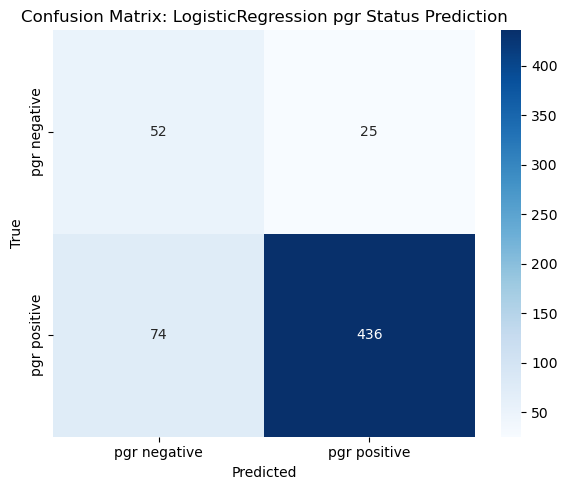


RandomForest test set accuracy: 0.915
Classification report:
               precision    recall  f1-score   support

 ER negative       0.74      0.55      0.63        77
 ER positive       0.93      0.97      0.95       510

    accuracy                           0.91       587
   macro avg       0.84      0.76      0.79       587
weighted avg       0.91      0.91      0.91       587



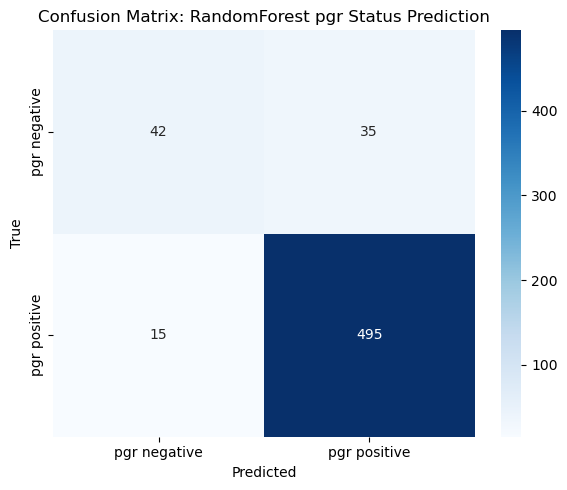


SVC test set accuracy: 0.867
Classification report:
               precision    recall  f1-score   support

 ER negative       0.49      0.62      0.55        77
 ER positive       0.94      0.90      0.92       510

    accuracy                           0.87       587
   macro avg       0.72      0.76      0.74       587
weighted avg       0.88      0.87      0.87       587



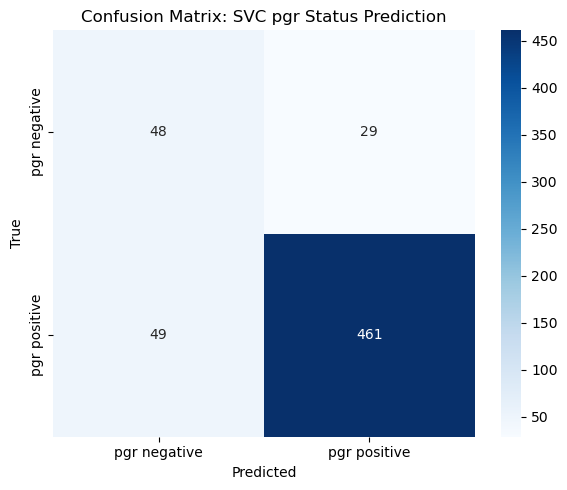

In [52]:
er_col = [col for col in clinical_df.columns if "pgr status" in col.lower()]
if er_col:
    pgr_status = clinical_df[er_col[0]]
    valid_mask = ~pgr_status.isnull()
    X_umap = umap_df.loc[valid_mask, ["UMAP1", "UMAP2"]]
    y_er = pgr_status[valid_mask].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_umap, y_er, test_size=0.2, random_state=42, stratify=y_er
    )

    # Define models and parameter grids
    models_and_params = {
        "LogisticRegression": (
            LogisticRegression(class_weight="balanced", max_iter=1000),
            {
                "C": [0.01, 0.1, 1, 10, 100],
                "solver": ["liblinear", "lbfgs"]
            }
        ),
        "RandomForest": (
            RandomForestClassifier(class_weight="balanced", random_state=42),
            {
                "n_estimators": [50, 100, 200],
                "max_depth": [None, 5, 10, 20]
            }
        ),
        "SVC": (
            SVC(class_weight="balanced", probability=True, random_state=42),
            {
                "C": [0.1, 1, 10],
                "kernel": ["linear", "rbf"]
            }
        )
    }

    best_models = {}
    for name, (model, param_grid) in models_and_params.items():
        print(f"\nGrid search for {name}...")
        grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train, y_train)
        print(f"Best params: {grid.best_params_}")
        print(f"Best CV accuracy: {grid.best_score_:.3f}")
        best_models[name] = grid.best_estimator_

    # Evaluate best models on test set
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n{name} test set accuracy: {acc:.3f}")
        print("Classification report:\n", classification_report(y_test, y_pred, target_names=["ER negative", "ER positive"]))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["pgr negative", "pgr positive"],
                    yticklabels=["pgr negative", "pgr positive"])
        plt.title(f"Confusion Matrix: {name} pgr Status Prediction")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
else:
    print("No pgr status column found in clinical_df.")

# Conclusion

In this analysis, we applied UMAP dimensionality reduction to gene expression data and explored the relationships between key breast cancer biomarkers (ER, HER2, PGR, KI67) and the resulting low-dimensional embeddings. We performed supervised machine learning using the UMAP features to predict biomarker status, evaluating models such as Logistic Regression, Random Forest, and SVC with cross-validation and grid search.

**Key Results:**
- UMAP embeddings revealed clear separation for ER status, with high silhouette scores and strong clustering performance (Adjusted Rand Index).
- Supervised models achieved high accuracy for ER status prediction (Logistic Regression and Random Forest >95% accuracy).
- HER2 and PGR status were more challenging to predict from UMAP embeddings, but grid search and model tuning improved performance.
- Confusion matrices and classification reports provided detailed insights into model strengths and weaknesses for each biomarker.

Overall, UMAP-based embeddings of gene expression data are highly informative for ER status and moderately predictive for other biomarkers, supporting their utility in downstream clinical and research applications.